# Summary

* There is not consensus on the feature associating the largest variance between feature sets.
* The general amount of feature variance increases with reduced amount of artifacts in the images through slice removal.

In [1]:
import sys
sys.path.append('./../prepping/')

import numpy as np
import pandas as pd

from scipy import linalg
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.spatial import distance

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Original Images Features

In [2]:
_y_orig = pd.read_csv('./../../data_source/to_analysis/original_images/dfs_original_images.csv', index_col=0)
y_orig = np.squeeze(_y_orig.values)

X_orig = pd.read_csv('./../../data_source/to_analysis/original_images/all_features_original_images.csv',index_col=0)
X_orig.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,60.832877,0.000000,39.0,1,0,0,0,0,0,1,...,47916.617451,0.094457,0.178525,0.358043,6.057050,25.566977,101.349019,21.616549,7.384,124.870726
4,49.906849,4.786027,33.0,0,0,0,0,0,0,1,...,19579.702532,0.070352,0.125185,0.238295,6.021110,27.043416,112.933552,15.296275,3.406,41.554406
5,54.238356,0.000000,42.0,0,0,0,0,0,0,1,...,14251.207526,0.054852,0.099392,0.191019,2.465487,10.711840,44.417785,14.473272,7.934,86.228420
8,54.687671,18.343836,0.0,1,0,0,0,0,0,0,...,7766.277251,0.024052,0.038650,0.070961,0.557200,2.723527,11.765552,10.510859,26.926,205.413389
10,61.728767,0.000000,35.0,1,0,0,0,0,0,0,...,2229.551107,0.029594,0.044499,0.082635,0.583427,3.013379,12.730022,7.213190,6.041,32.103770


In [3]:
X_orig.shape

(198, 553)

In [4]:
X_orig_shape = X_orig.filter(regex='shape')
X_orig_PET = X_orig.filter(regex='PET')
X_orig_CT = X_orig.filter(regex='CT')

X_orig_shape.shape, X_orig_PET.shape, X_orig_CT.shape

((198, 14), (198, 250), (198, 247))

In [5]:
scaler = StandardScaler()

X_orig_shape_std = scaler.fit_transform(X_orig_shape)
X_orig_PET_std = scaler.fit_transform(X_orig_PET)
X_orig_CT_std = scaler.fit_transform(X_orig_CT)

X_orig_shape_std.shape, X_orig_PET_std.shape, X_orig_CT_std.shape

((198, 14), (198, 250), (198, 247))

Text(0.5, 0, 'Patient Indicator')

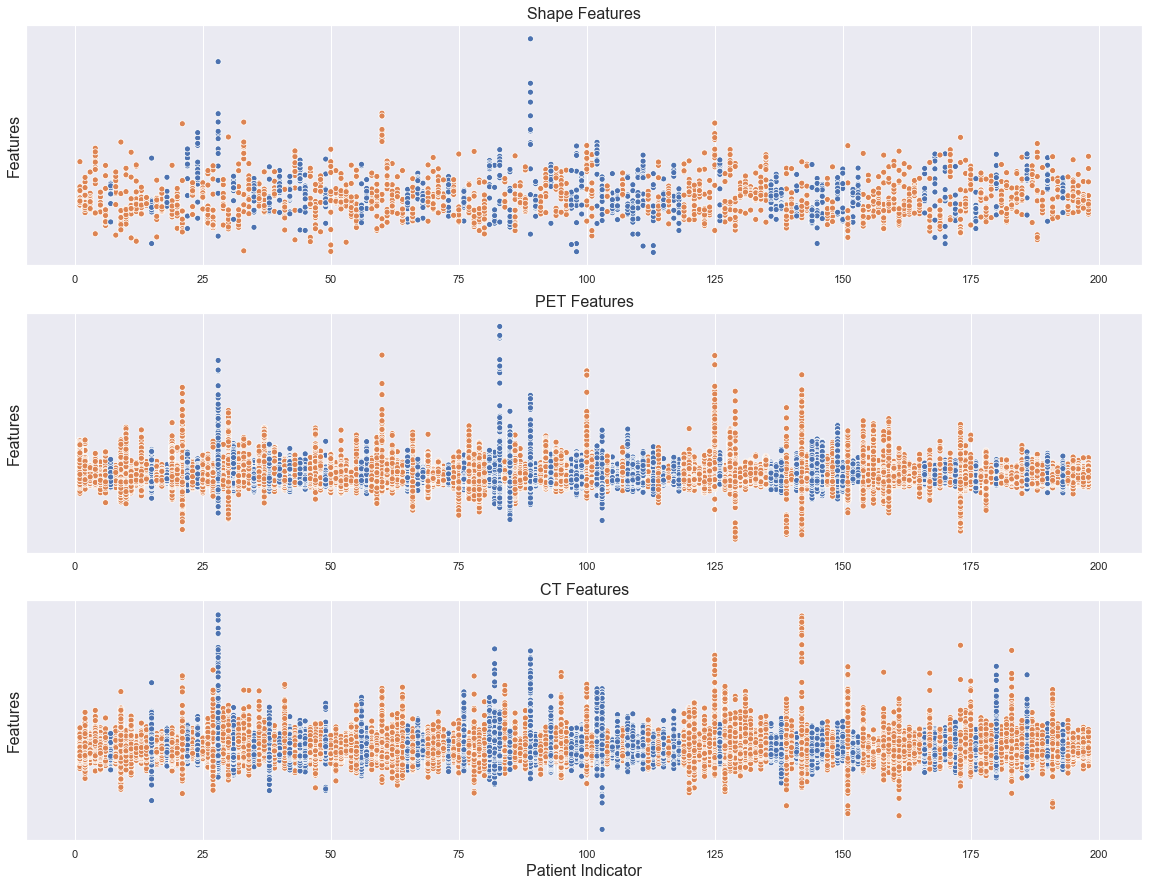

In [6]:
_hue = y_orig==0
x_coords = np.arange(1, np.size(y_orig) + 1)

sns.set()
fig, axis = plt.subplots(
    nrows=3, figsize=(20, 15)
)
axis[0].set_title('Shape Features', fontsize=16)
for shape_col in X_orig_shape_std.T:
    sns.scatterplot(
        x=x_coords,
        y=shape_col,
        hue=_hue,
        legend=False,
        ax=axis[0]
    )
axis[0].set_ylabel('Features', fontsize=16)
axis[0].set_yticks([])

axis[1].set_title('PET Features', fontsize=16)
for PET_col in X_orig_PET_std.T:
    sns.scatterplot(
        x=x_coords,
        y=PET_col,
        hue=_hue,
        legend=False,
        ax=axis[1]
    )
axis[1].set_ylabel('Features', fontsize=16)
axis[1].set_yticks([])

axis[2].set_title('CT Features', fontsize=16)
for CT_col in X_orig_CT_std.T:
    sns.scatterplot(
        x=x_coords,
        y=CT_col,
        hue=_hue,
        legend=False,
        ax=axis[2]
    )
axis[2].set_ylabel('Features', fontsize=16)
axis[2].set_yticks([])

plt.xlabel('Patient Indicator', fontsize=16)

# Removed Broken Images

In [7]:
_y_rb = pd.read_csv('./../../data_source/to_analysis/removed_broken_images/dfs_removed_broken_images.csv', index_col=0)
y_rb = np.squeeze(_y_rb.values)
X_rb = pd.read_csv('./../../data_source/to_analysis/removed_broken_images/all_features_removed_broken_images.csv',index_col=0)
X_rb.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,60.832877,0.000000,39.0,1,0,0,0,0,0,1,...,48538.451779,0.092061,0.177064,0.358195,6.326227,26.103315,102.319537,21.616549,7.384,124.870726
4,49.906849,4.786027,33.0,0,0,0,0,0,0,1,...,19870.769325,0.067769,0.123210,0.237406,6.417218,27.937213,114.706035,15.296275,3.406,41.554406
5,54.238356,0.000000,42.0,0,0,0,0,0,0,1,...,14247.890339,0.055490,0.100416,0.193077,2.453154,10.675290,44.266260,14.473272,7.934,86.228420
8,54.687671,18.343836,0.0,1,0,0,0,0,0,0,...,7754.113657,0.024245,0.039036,0.071547,0.555559,2.710372,11.728725,10.510859,26.926,205.413389
10,61.728767,0.000000,35.0,1,0,0,0,0,0,0,...,2230.944157,0.029951,0.044956,0.083506,0.581582,3.003438,12.674331,7.213190,6.041,32.103770


In [8]:
X_rb.shape

(195, 553)

In [9]:
X_rb_shape = X_rb.filter(regex='shape')
X_rb_PET = X_rb.filter(regex='PET')
X_rb_CT = X_rb.filter(regex='CT')

X_rb_shape.shape, X_rb_PET.shape, X_rb_CT.shape

((195, 14), (195, 250), (195, 247))

In [10]:
scaler = StandardScaler()

X_rb_shape_std = scaler.fit_transform(X_rb_shape)
X_rb_PET_std = scaler.fit_transform(X_rb_PET)
X_rb_CT_std = scaler.fit_transform(X_rb_CT)

Text(0.5, 0, 'Patient Indicator')

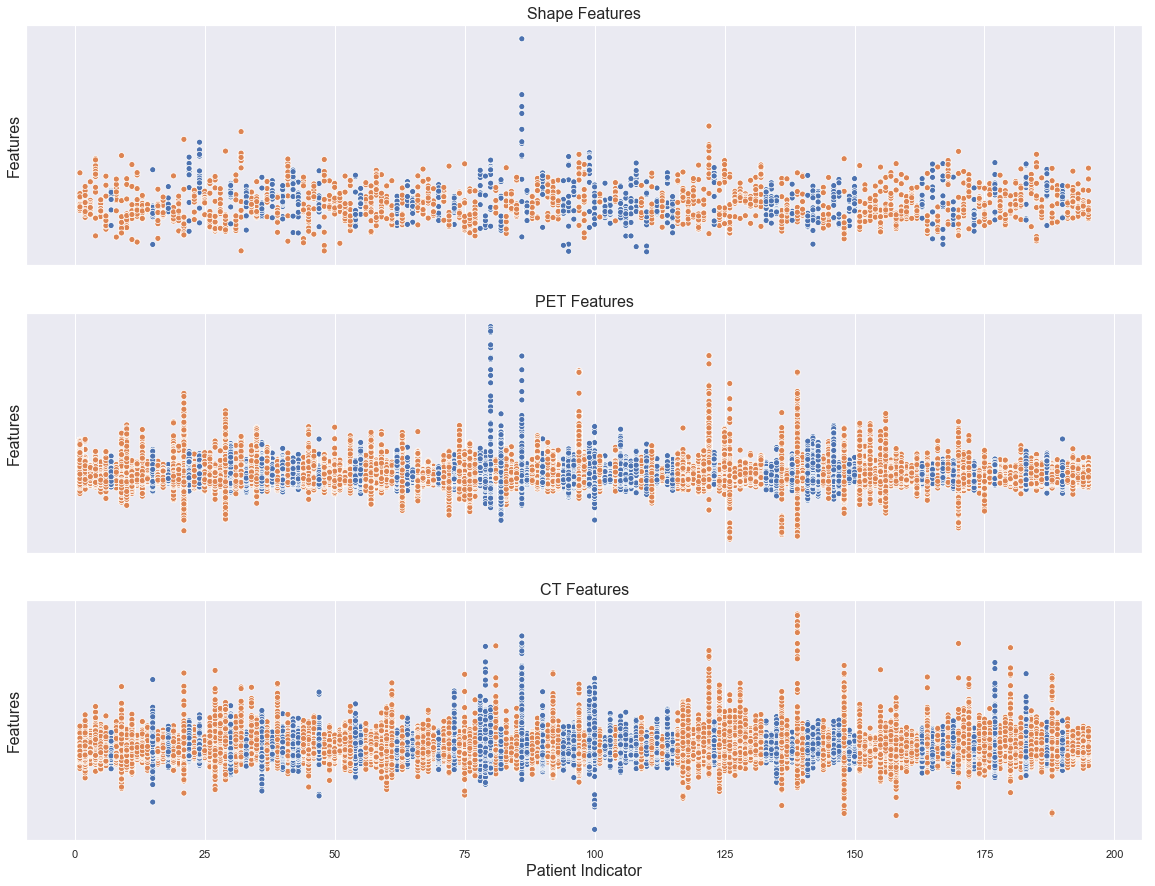

In [11]:
_hue = y_rb==0
x_coords = np.arange(1, np.size(y_rb) + 1)

sns.set()
fig, axis = plt.subplots(
    nrows=3, 
    sharex=True,
    figsize=(20, 15)
)
axis[0].set_title('Shape Features', fontsize=16)
for shape_col in X_rb_shape_std.T:
    sns.scatterplot(
        x=x_coords,
        y=shape_col,
        hue=_hue,
        legend=False,
        ax=axis[0]
    )
axis[0].set_ylabel('Features', fontsize=16)
axis[0].set_yticks([])

axis[1].set_title('PET Features', fontsize=16)
for PET_col in X_rb_PET_std.T:
    sns.scatterplot(
        x=x_coords,
        y=PET_col,
        hue=_hue,
        legend=False,
        ax=axis[1]
    )
axis[1].set_ylabel('Features', fontsize=16)
axis[1].set_yticks([])

axis[2].set_title('CT Features', fontsize=16)
for CT_col in X_rb_CT_std.T:
    sns.scatterplot(
        x=x_coords,
        y=CT_col,
        hue=_hue,
        legend=False,
        ax=axis[2]
    )
axis[2].set_ylabel('Features', fontsize=16)
axis[2].set_yticks([])

plt.xlabel('Patient Indicator', fontsize=16)

# Removed Broken Images and Slices Features

In [12]:
y_rb_as = np.squeeze(pd.read_csv('./../../data_source/to_analysis/removed_broken_slices/dfs_removed_broken_slices.csv', index_col=0).values)
X_rb_as = pd.read_csv('./../../data_source/to_analysis/removed_broken_slices/all_features_removed_broken_slices.csv',index_col=0)
X_rb_as.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,60.832877,0.000000,39.0,1,0,0,0,0,0,1,...,49.308852,0.000127,0.000164,0.001203,0.060466,0.214173,0.297980,21.616549,7.384,124.870726
4,49.906849,4.786027,33.0,0,0,0,0,0,0,1,...,67.042138,0.004490,0.004617,0.006914,0.024249,0.091105,0.388307,15.296275,3.406,41.554406
5,54.238356,0.000000,42.0,0,0,0,0,0,0,1,...,106.093147,0.000985,0.000963,0.002301,0.039365,0.193554,0.592523,14.473272,7.934,86.228420
8,54.687671,18.343836,0.0,1,0,0,0,0,0,0,...,174.011183,0.000500,0.000441,0.001784,0.024303,0.133040,0.282213,10.510859,26.926,205.413389
10,61.728767,0.000000,35.0,1,0,0,0,0,0,0,...,36.475226,0.000115,0.000414,0.001741,0.096332,0.245306,0.538985,7.213190,6.041,32.103770


In [13]:
X_rb_as.shape

(196, 553)

In [14]:
X_rb_as_shape = X_rb_as.filter(regex='shape')
X_rb_as_PET = X_rb_as.filter(regex='PET')
X_rb_as_CT = X_rb_as.filter(regex='CT')

X_rb_as_shape.shape, X_rb_as_PET.shape, X_rb_as_CT.shape

((196, 14), (196, 250), (196, 247))

In [15]:
scaler = StandardScaler()

X_rb_as_shape_std = scaler.fit_transform(X_rb_as_shape)
X_rb_as_PET_std = scaler.fit_transform(X_rb_as_PET)
X_rb_as_CT_std = scaler.fit_transform(X_rb_as_CT)

X_rb_as_shape_std.shape, X_rb_as_PET_std.shape, X_rb_as_CT_std.shape

((196, 14), (196, 250), (196, 247))

Text(0.5, 0, 'Patient Indicator')

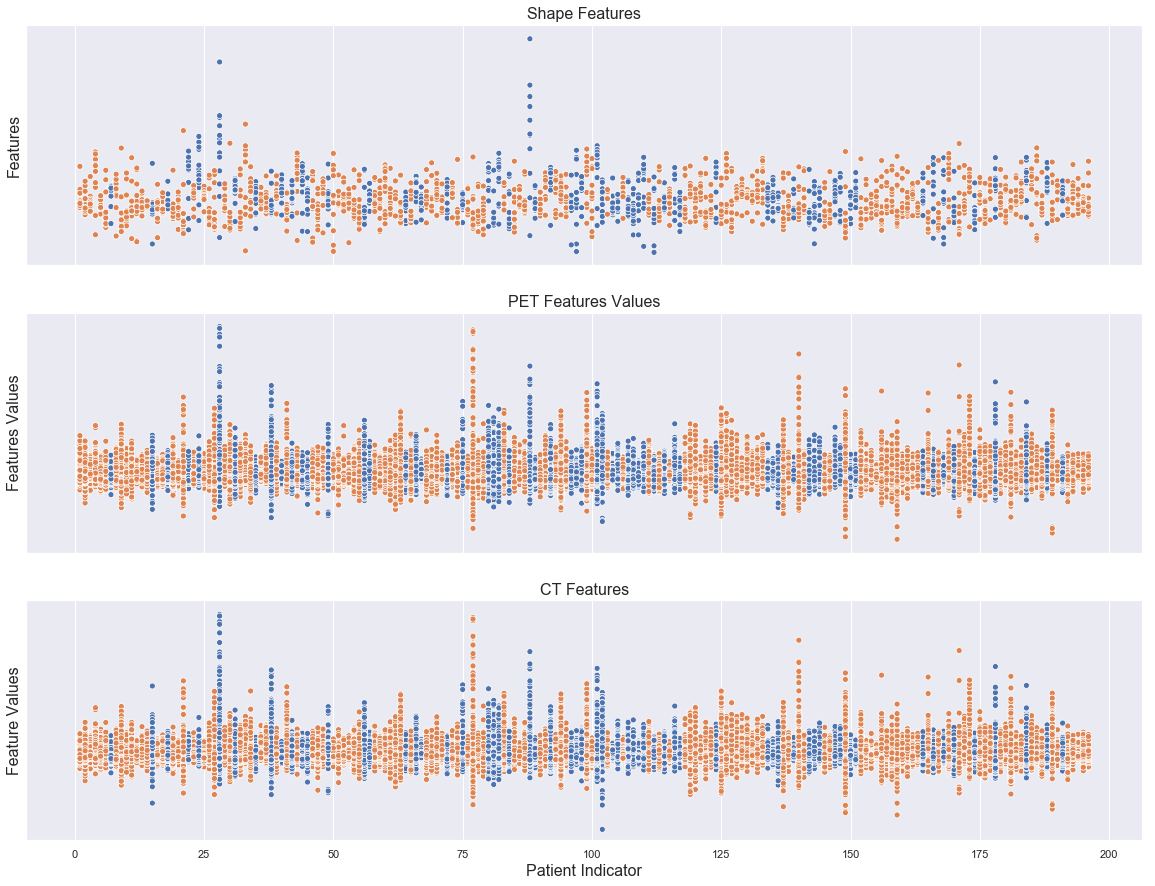

In [16]:
_hue = y_rb_as==0
x_coords = np.arange(1, np.size(y_rb_as) + 1)

sns.set()
fig, axis = plt.subplots(
    nrows=3, 
    sharex=True,
    figsize=(20, 15)
)
axis[0].set_title('Shape Features', fontsize=16)
for shape_col in X_rb_as_shape_std.T:
    sns.scatterplot(
        x=x_coords,
        y=shape_col,
        hue=_hue,
        legend=False,
        ax=axis[0]
    )
axis[0].set_ylabel('Features', fontsize=16)
axis[0].set_yticks([])

axis[1].set_title('PET Features Values', fontsize=16)
for PET_col in X_rb_as_PET_std.T:
    sns.scatterplot(
        x=x_coords,
        y=PET_col,
        hue=_hue,
        legend=False,
        ax=axis[1]
    )
axis[1].set_ylabel('Features Values', fontsize=16)
axis[1].set_yticks([])

axis[2].set_title('CT Features', fontsize=16)
for CT_col in X_rb_as_CT_std.T:
    sns.scatterplot(
        x=x_coords,
        y=CT_col,
        hue=_hue,
        legend=False,
        ax=axis[2]
    )
axis[2].set_ylabel('Feature Values', fontsize=16)
axis[2].set_yticks([])

plt.xlabel('Patient Indicator', fontsize=16)

# Feature Variances

**QUESTIONS:** 
* How is the feature associating the most variance ranked by ML algorithms?
* Are feature variances increasing with (assumed) decreasing amount of artifacts?

## Original Images

In [17]:
# Original images.
X_orig_no_clinical = pd.concat((X_orig_shape, X_orig_PET, X_orig_CT), axis=1)
X_orig_no_clinical = X_orig_no_clinical / X_orig_no_clinical.max(axis=0)

X_orig_vars = X_orig_no_clinical.var()
X_orig_max_var = X_orig_vars.max()
print(X_orig_max_var)
list(X_orig_no_clinical.columns[np.where(X_orig_max_var == X_orig_vars)])

0.32480270956957163


['CT_original_glcm_Imc1_32bins']

In [18]:
# Removed broken images.
X_rb_no_clinical = pd.concat((X_rb_shape, X_rb_PET, X_rb_CT), axis=1)
X_rb_no_clinical = X_rb_no_clinical / X_rb_no_clinical.max(axis=0)

X_rb_vars = X_rb_no_clinical.var()
X_rb_max_var = X_rb_vars.max()
print(X_rb_max_var)
list(X_rb_no_clinical.columns[np.where(X_rb_max_var == X_rb_vars)])

0.365734622086875


['CT_original_glcm_ClusterShade_32bins']

In [19]:
# Removed broken images and broken slices.
X_rb_as_no_clinical = pd.concat((X_rb_as_shape, X_rb_as_PET, X_rb_as_CT), axis=1)
X_rb_as_no_clinical = X_rb_as_no_clinical / X_rb_as_no_clinical.max(axis=0)

X_rb_as_vars = X_rb_as_no_clinical.var()
X_rb_as_max_var = X_rb_as_vars.max()
print(X_rb_as_max_var)
list(X_rb_as_no_clinical.columns[np.where(X_rb_as_max_var == X_rb_as_vars)])

0.7175070521344573


['PET_original_glcm_Imc1_32bins', 'CT_original_glcm_Imc1_32bins']

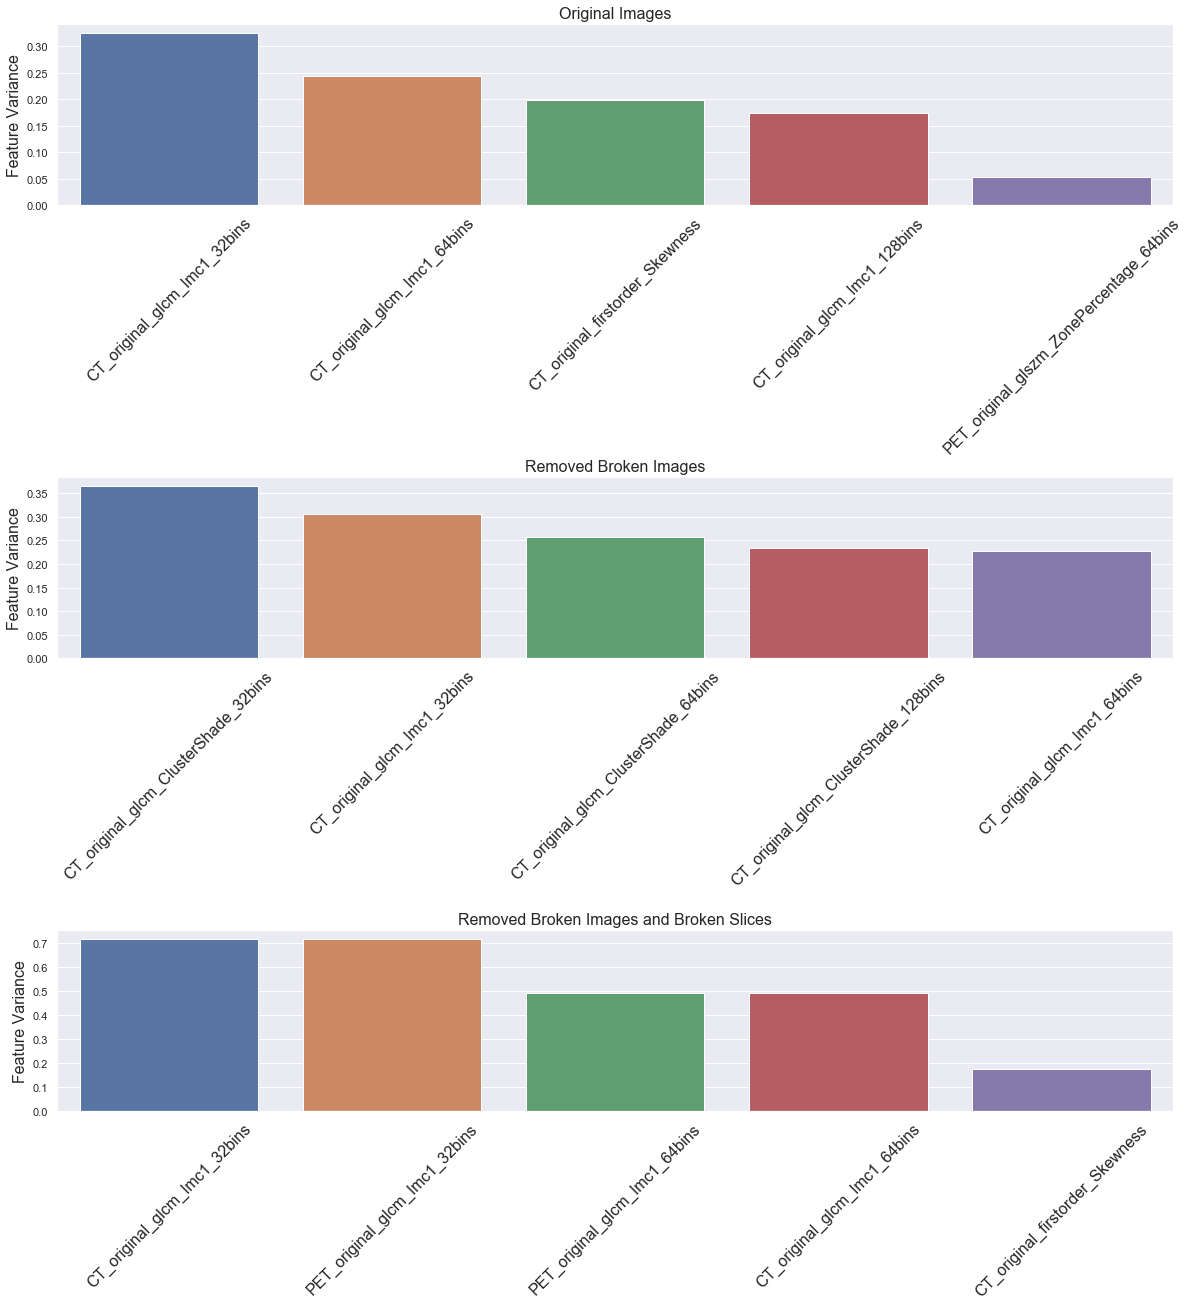

In [20]:
# The top n largest feature variances.
n = 5
x_coords = np.arange(n)

X_orig_vars_sorted = X_orig_vars.sort_values(inplace=False, ascending=False)
X_rb_vars_sorted = X_rb_vars.sort_values(inplace=False, ascending=False)
X_rb_as_vars_sorted = X_rb_as_vars.sort_values(inplace=False, ascending=False)

sns.set()
fig, axes = plt.subplots(
    nrows=3, figsize=(20, 20)
)
axes[0].set_title('Original Images', fontsize=16)
sns.barplot(
    x=x_coords,
    y=X_orig_vars_sorted[:n],
    ax=axes[0]
)
axes[0].set_xticklabels(X_orig_vars_sorted.index, rotation=45, fontsize=16)
axes[0].set_ylabel('Feature Variance', fontsize=16)


axes[1].set_title('Removed Broken Images', fontsize=16)
sns.barplot(
    x=x_coords,
    y=X_rb_vars_sorted[:n],
    ax=axes[1]
)
axes[1].set_xticklabels(X_rb_vars_sorted.index, rotation=45, fontsize=16)
axes[1].set_ylabel('Feature Variance', fontsize=16)


axes[2].set_title('Removed Broken Images and Broken Slices', fontsize=16)
sns.barplot(
    x=x_coords,
    y=X_rb_as_vars_sorted[:n],
    ax=axes[2]
)
axes[2].set_xticklabels(X_rb_as_vars_sorted.index, rotation=45, fontsize=16)
axes[2].set_ylabel('Feature Variance', fontsize=16)

# NOTE: To adjust distance between subplots.
plt.subplots_adjust(hspace=1.5)

# 